In [1]:
### importing lib

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np

In [2]:
image_directory = r"D:\Breast-Cancer\Processed\anamoly"
SIZE = 240
dataset = [] 
label = [] ###We will add 1 to all Cancer and Benign images and 0 to Normal.



In [3]:
image_directory + r'\normal'

'D:\\Breast-Cancer\\Processed\\anamoly\\normal'

#### only using two classes, normal mamograms and diseased mammogram 

In [4]:
tumor_img = os.listdir(image_directory + r'\\Parsited')
for i, image_name in enumerate(tumor_img):
    
    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[2] == 'jpg'):
        image = cv2.imread(image_directory + '\\Parsited\\' + image_name)
#         print (image)
    
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [5]:
uninfected_images = os.listdir(image_directory + r'\normal')
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[2] == 'jpg'):
        image = cv2.imread(image_directory + '\\normal\\' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

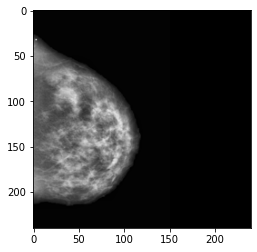

In [6]:
plt.imshow(dataset[100], cmap="hot")

In [7]:
## COnverting into Numpy Array
dataset = np.array(dataset)
label = np.array(label)

#Split into train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 42)

### Scaling dataset
X_train = X_train /255.
X_test = X_test /255.

In [8]:
#Since we are  using categorical cross entropy lossconverting Y values to categorical. 

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
#### VGG16 layers and  GlobalAveragePooling and dense prediction layers.


def get_model(input_shape = (240,240,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten. 
    x = Dense(2, activation="softmax")(x)  #We are defining this as multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model

In [20]:
model = get_model(input_shape = (240,240,3))
print(model.summary())



input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv

C:\Users\prana\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [22]:
 tf.keras.backend.clear_session()

In [23]:
### Using method to clear session after each epoch on callback

from tensorflow.keras.callbacks import Callback
import gc


class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs = None):
        gc.collect()
        tf.keras.backend.clear_session()
        
        
checkpoint_filepath = r"D:\model"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True)


callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 4),
    ClearMemory(),
    model_checkpoint_callback
]

In [24]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose = 1, 
                    validation_data=(X_test,y_test), callbacks = callbacks)

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6120 - accuracy: 0.6944

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1267s 3s/step - loss: 0.6120 - accuracy: 0.6944 - val_loss: 0.6067 - val_accuracy: 0.6805
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.6955

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1253s 3s/step - loss: 0.5801 - accuracy: 0.6955 - val_loss: 0.5837 - val_accuracy: 0.6837
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.7080

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1250s 3s/step - loss: 0.5532 - accuracy: 0.7080 - val_loss: 0.5590 - val_accuracy: 0.7125
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.7262

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1236s 3s/step - loss: 0.5257 - accuracy: 0.7262 - val_loss: 0.5361 - val_accuracy: 0.7503
Epoch 5/10
391/391 [==============================] - 1234s 3s/step - loss: 0.5019 - accuracy: 0.7501 - val_loss: 0.5210 - val_accuracy: 0.7266
Epoch 6/10
391/391 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.7643

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1235s 3s/step - loss: 0.4828 - accuracy: 0.7643 - val_loss: 0.4926 - val_accuracy: 0.7823
Epoch 7/10
391/391 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.7816

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1258s 3s/step - loss: 0.4671 - accuracy: 0.7816 - val_loss: 0.4773 - val_accuracy: 0.7881
Epoch 8/10
391/391 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.7871

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1244s 3s/step - loss: 0.4569 - accuracy: 0.7871 - val_loss: 0.4664 - val_accuracy: 0.7894
Epoch 9/10
391/391 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.7925

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1239s 3s/step - loss: 0.4467 - accuracy: 0.7925 - val_loss: 0.4548 - val_accuracy: 0.7977
Epoch 10/10
391/391 [==============================] - ETA: 0s - loss: 0.4426 - accuracy: 0.7960

INFO:tensorflow:Assets written to: D:\model\assets


INFO:tensorflow:Assets written to: D:\model\assets


391/391 [==============================] - 1230s 3s/step - loss: 0.4426 - accuracy: 0.7960 - val_loss: 0.4538 - val_accuracy: 0.7990


In [25]:
model.save(r'D:\model\Model.h5')

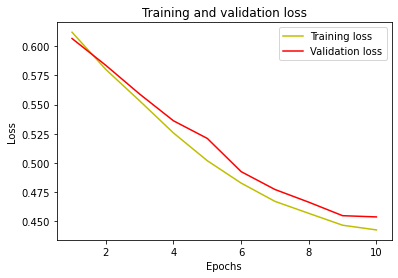

In [26]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

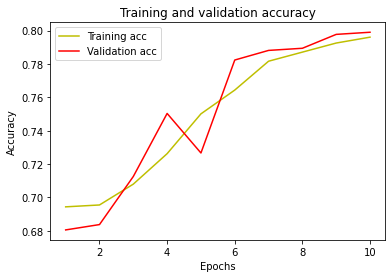

In [27]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
import tensorflow as tf

In [31]:
# model =tf.keras.models.load_model(r'D:\model\Model.h5')

In [30]:
#Check model accuracy on the test data
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")



49/49 [==============================] - 207s 4s/step - loss: 0.4538 - accuracy: 0.7990
Accuracy =  79.89756464958191 %


1/1 [==============================] - 0s 125ms/step
The prediction for this image is:  1
The actual label for this image is:  1


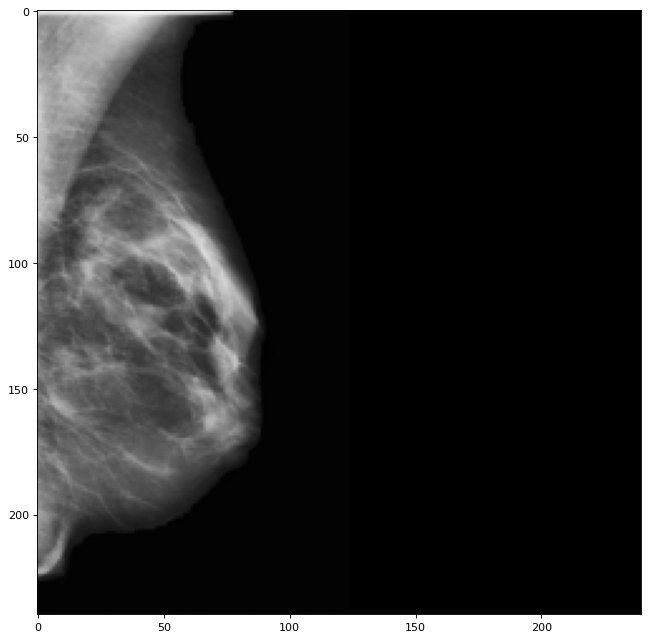

In [123]:
#Test on single image.
n=1000  #Select the index of image to be loaded for testing


img = X_test[n]
figure(figsize=(10,10), dpi=80)
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

In [32]:
tf.keras.backend.clear_session()
# tf.compat.v1.reset_default_graph()

In [33]:

#Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)



49/49 [==============================] - 214s 4s/step


[[309 190]
 [124 939]]


<AxesSubplot:>

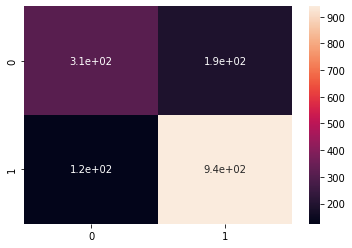

In [40]:
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  

print( cm)
sns.heatmap(cm, annot=True)

In [125]:
########################################################
#Identify all images classified as parasitized and plot heatmaps.


parasited_image_idx = np.where(y_pred == 1)[0]



predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
    
    
predicted_as_para = np.array(predicted_as_para)    

In [130]:
### Creating function to plot heatmap
### This shows predection and we can compared it to actual mammogram


from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 
from matplotlib.pyplot import figure


def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 2 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=1, threshold_rel=0.5, min_distance=10) 
    
    figure(figsize=(10,10), dpi=100)
    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

1/1 [==============================] - 0s 218ms/step
0


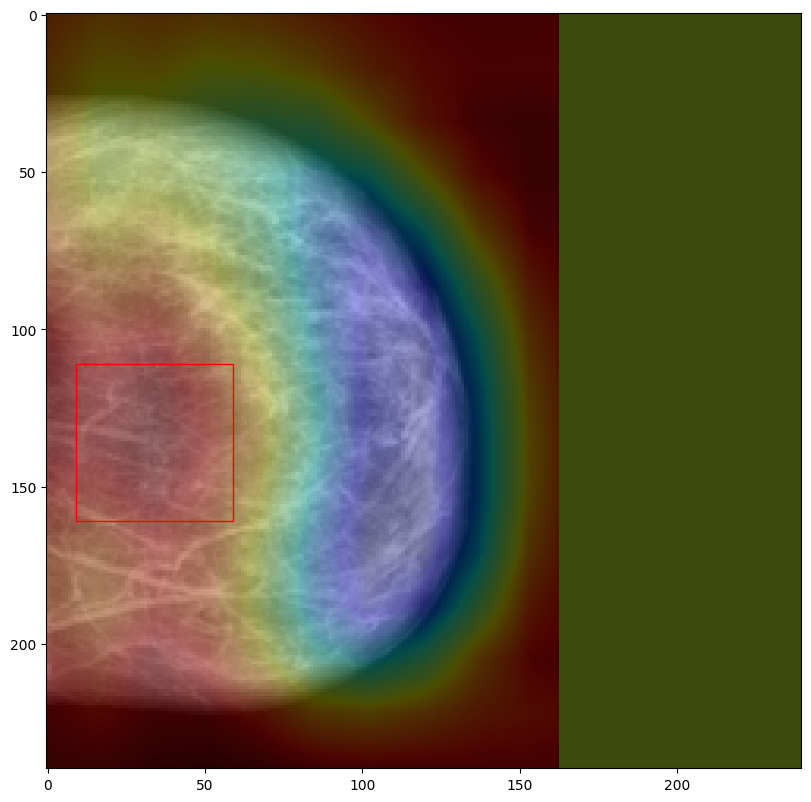

In [133]:
import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[im])



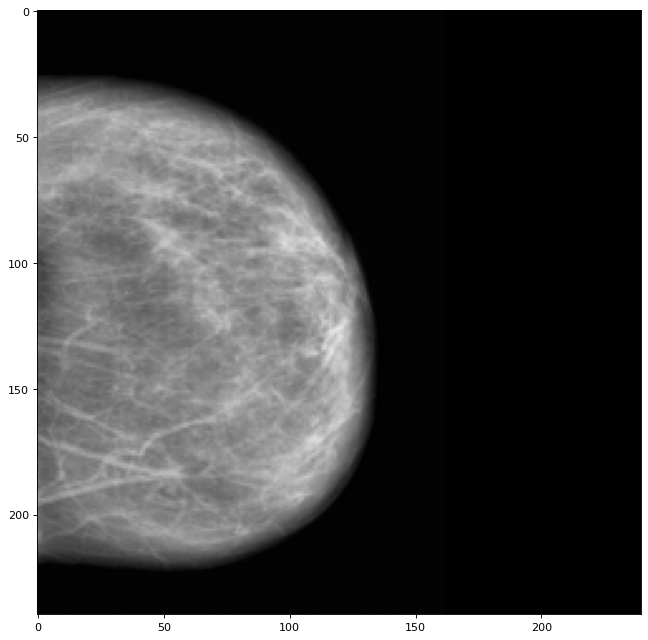

In [136]:
img = predicted_as_para[im]
figure(figsize=(10,10), dpi=80)
plt.imshow(predicted_as_para[im])